In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import warnings

warnings.filterwarnings('ignore', )

In [2]:
'''Функция для возвращения таблицы с метриками'''
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'MAE'}, data=[0])

    report['MAE'] = mean_absolute_error(y_test, model.predict(X_test))
    report['MSE'] = mean_squared_error(y_test, model.predict(X_test))
    report['RMSE'] = (mean_squared_error(y_test, model.predict(X_test))) ** 0.5


    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [3]:
SEED = 666

In [4]:
boston = load_boston();


In [5]:
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

In [6]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


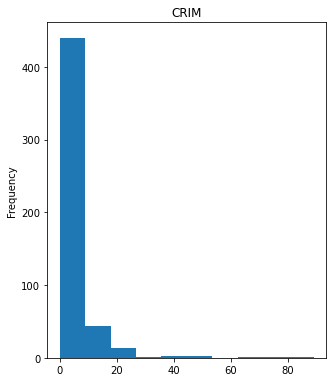

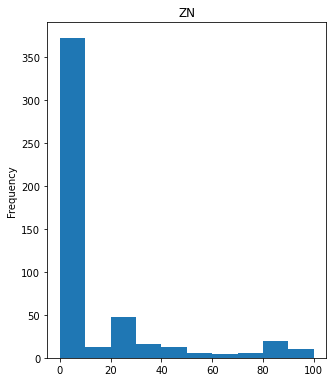

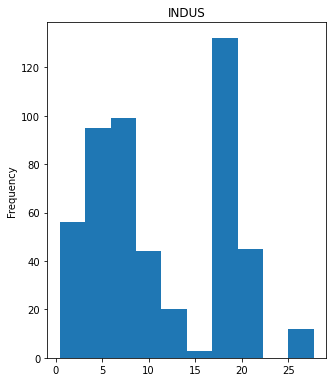

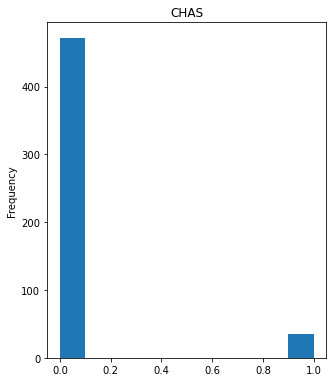

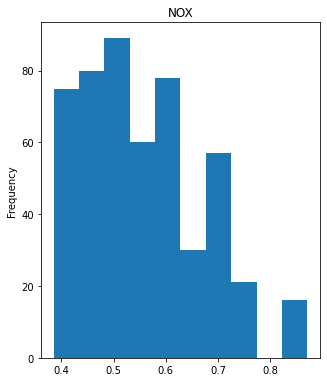

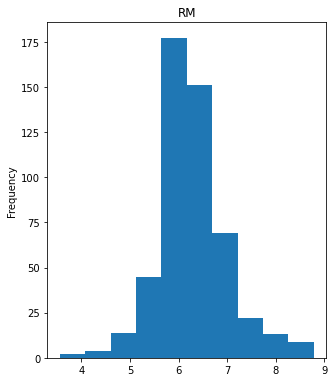

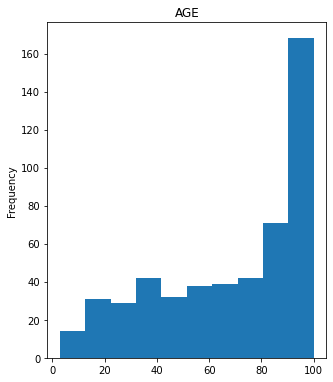

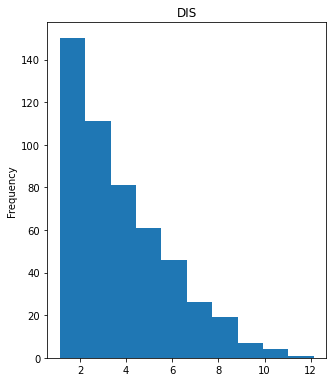

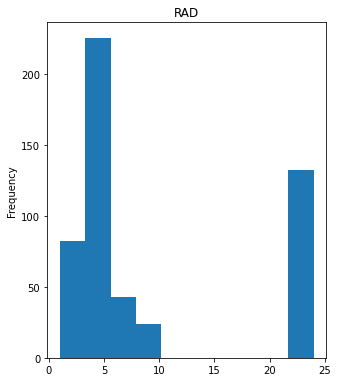

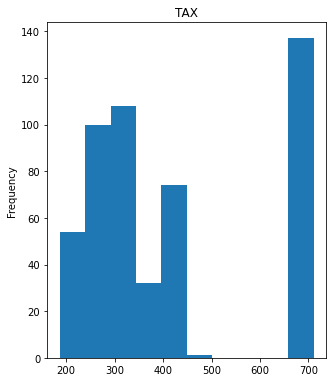

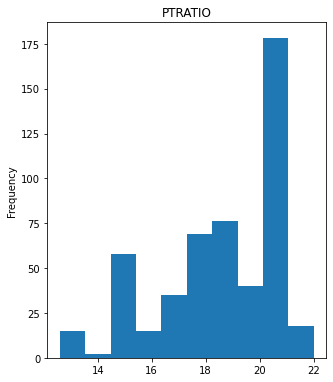

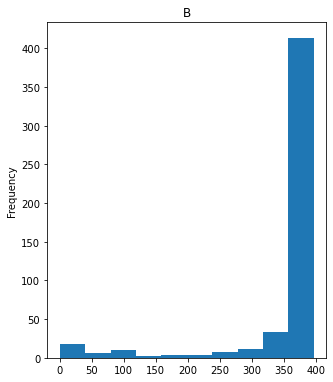

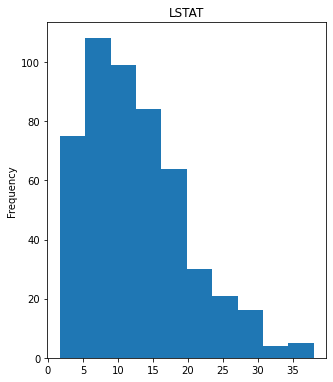

In [7]:
for  n, col  in enumerate(df.columns[:-1], start=1):
    plt.figure(figsize=(5,95))
    plt.subplot(len(df.columns[:-1]),1 , n)
    df[col].plot(kind='hist')
    plt.title(col)
    plt.show()
    

### Видим, что не все признаки имеют распределение, похожее на нормальное. 

#### Random forest и Gradient Boosting на нестандартизированных данных.

In [8]:
X = boston['data']
y = boston['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, shuffle=False, test_size=.2)

In [10]:
#Не будем делать GridSearch для подбора гиперпараметров. Для эксперемента достаточно будет ручного ввода

## Random Forest

In [11]:
forest_model = RandomForestRegressor(max_depth=5, random_state=SEED)


In [12]:
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=666)

In [13]:
y_pred = forest_model.predict(X_test)


In [14]:
# Создаем таблицу, где будем вести учет результатов
df_report = pd.DataFrame(columns={'MAE'}, data=[0])

df_report['MAE'] = mean_absolute_error(y_test, y_pred)
df_report['MSE'] = mean_squared_error(y_test, y_pred)
df_report['RMSE'] = (mean_squared_error(y_test, y_pred)) ** 0.5

df_report.index = ['RandomForest']

In [15]:
df_report

,MAE,MSE,RMSE
RandomForest,3.05673,18.85405,4.342125


## Gradient Boosting (Light GBM)

In [16]:
grad_model = lgb.LGBMRegressor(max_depth=5, random_state=SEED)

In [17]:
grad_model.fit(X_train, y_train)

LGBMRegressor(max_depth=5, random_state=666)

In [18]:
y_pred = grad_model.predict(X_test)


In [19]:
df_report = get_scores(df_report, grad_model, X_test, y_test, 'LGBM')

### Нормализуем, стандартизируем, робустим

In [20]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [21]:
X_train_mm = min_max_scaler.fit_transform(X_train)
X_test_mm = min_max_scaler.transform(X_test)

X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_rob = rob_scaler.fit_transform(X_train)
X_test_rob = rob_scaler.transform(X_test)

### RF

In [22]:
rf_mm = RandomForestRegressor(max_depth=5, random_state=SEED)
rf_std = RandomForestRegressor(max_depth=5, random_state=SEED)
rf_rob = RandomForestRegressor(max_depth=5, random_state=SEED)


In [23]:
rf_mm.fit(X_train_mm, y_train)
rf_std.fit(X_train_std, y_train)
rf_rob.fit(X_train_rob, y_train)

RandomForestRegressor(max_depth=5, random_state=666)

In [24]:
df_report = get_scores(df_report, rf_mm, X_test_mm, y_test, 'RF_min_max')
df_report = get_scores(df_report, rf_std, X_test_std, y_test, 'RF_std')
df_report = get_scores(df_report, rf_rob, X_test_rob, y_test, 'RF_rob')

In [25]:
df_report

,MAE,MSE,RMSE
RandomForest,3.056730,18.854050,4.342125
LGBM,4.068169,28.012930,5.292724
RF_min_max,3.056730,18.854050,4.342125
RF_std,3.057014,18.855963,4.342345
RF_rob,3.056935,18.856675,4.342427


### LGBM

In [26]:
lg_mm = lgb.LGBMRegressor(max_depth=5, random_state=SEED)
lg_std = lgb.LGBMRegressor(max_depth=5, random_state=SEED)
lg_rob = lgb.LGBMRegressor(max_depth=5, random_state=SEED)

In [27]:
lg_mm.fit(X_train_mm, y_train)
lg_std.fit(X_train_std, y_train)
lg_rob.fit(X_train_rob, y_train)

LGBMRegressor(max_depth=5, random_state=666)

In [28]:
df_report = get_scores(df_report, lg_mm, X_test_mm, y_test, 'LGBM_min_max')
df_report = get_scores(df_report, lg_std, X_test_std, y_test, 'LGMB_std')
df_report = get_scores(df_report, lg_rob, X_test_rob, y_test, 'LGBM_rob')

In [29]:
df_report

,MAE,MSE,RMSE
RandomForest,3.056730,18.854050,4.342125
LGBM,4.068169,28.012930,5.292724
RF_min_max,3.056730,18.854050,4.342125
RF_std,3.057014,18.855963,4.342345
RF_rob,3.056935,18.856675,4.342427
LGBM_min_max,4.054314,27.794953,5.272092
LGMB_std,4.089340,27.330085,5.227818
LGBM_rob,4.056895,27.027013,5.198751


### Вывод

У нас стояла задача выяснить как нормализация и стандартизация принаков влияет на результат работы cлучайных деревьев и uрадиентного бустинга (выбрали LGBM). Мы не избавлялись от выбросов и не работали с таргетом. В ходе эксперимента выяснилось, что такая предобработка признаков, для моделей, основанных на деревьях изменяет метрики незначительно.

Для RF они стали немного хуже.(MAE 3.0567 против MAE_std 3.0570, MAE_rob 3.0569)

Для LGBM они стали немного лучше кроме StandarScaler(MAE 4.0681 против MAE_min_max 4.0543, MAE_rob 4.0568)